## Purpose:

The purpose of this notebook is to explore the use of dynamic time warping in the classification of time series data. Data is generated by embedding one cycle of a randomly selected sine, square or sawtooth wave within a greater signal. The locations of the events within the greater signal, the frequencies and amplitudes of the events are randomly selected within given ranges. Further background noise proportional to the signal amplitude is added to the signal. A first goal is to devise a methodology in which like-event (i.e. sine, square and sawtooth) types cluster together without the use of ground-truth labels. A second goal to devise a methodology to predict event-types in unseen data. 


## Background

The workhorse technique of this notebook is dynamic time warping. Dynamic time warping is a technique for measuring the similarity between two temporal signals which might vary in speed. For instance, imagine two sine waves with different frequencies. Despite the fact that they are similar in shape, standard similarity measurements like euclidean distance or covariance would not be able to capture this similarity, as over a sufficient ammount of time the correlation between two sinewaves of different frequencies tends to zero. Dynamic time warping solves this problem by finding optimal matches between coordinates of the different time series, allowing us to warp the first signal into the time domain of the second signal or vice versa. We can then use the euclidean distance between the matched and warped time series as a measure of similarity between the two time series. 

DTW also allows us to average multiple time series together using a method called barycenter averaging. Barycenter averaging works by using a template signal as a common link between coordinates of the multiple time series to be averaged. At each iteration, dtw is calculated between the template signal and each of the multiple time series to be averaged. For each coordinate of the template signal coordinates of the multiple time series associated with this coordinate are averaged together yielding a new average time series. The process is iteratively repeated until convergence is achieved. In order to perform this method, the process must be seeded with a starter template which is usually selected from the multiple time series to be averaged.

One issue with the naive dtw algorithm is that it has a quadratic time complexity, meaning that the time that it takes to run the algorithm goes up with the squared length of the time series. Various algorithms exist for improving the time complexity of naive dtw. Here, I've implemented a version of the pruned dtw algorithm. Pruned dtw works by cleverly eliminating calculations which are guaranteed not to yield the optimal warping path using a calculated upper bound threshold. For further information on naive dtw, pruned dtw or barycenter averaging see the links below:

* [Youtube playlist explaining the naive dtw algorithm along with sample python code](https://www.youtube.com/playlist?list=PLmZlBIcArwhMJoGk5zpiRlkaHUqy5dLzL)
* [Paper explaining pruned dtw algorithm](http://sites.labic.icmc.usp.br/dfs/pdf/SDM_PrunedDTW.pdf)
* [Paper explaining barycenter averaging](http://www.francois-petitjean.com/Research/Petitjean2011-PR.pdf)



### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from copy import deepcopy
from scipy import signal

### Helper Functions

Various helper functions including an implementation of pruned dtw algorithm and barycenter averaging.

In [3]:
def squarewave(timevector = np.linspace(0,1,500), amp =1 , freq = 5,  phase = 0):
    sine = np.sin(2*np.pi*freq*timevector + phase)
    square = np.zeros(len(sine))
    for i, val in np.ndenumerate(sine):
        if val> 1e-10:
            square[i] = amp
        elif val < -1e-10:
            square[i] = -amp
        else:
            square[i] = 0
    return timevector, square

def sinewave(timevector = np.linspace(0,1,500), amp =1 , freq = 5,  phase = 0):
    sinewave = amp*np.sin(2*np.pi*freq*timevector+phase)
    return timevector, sinewave
    
def addnoise(signal1, noise_amp):
    return signal1 + np.random.normal(scale = noise_amp, size = len(signal1))

def dtw_average(signals, average_signal, iterations, window_size):
    nsignals = len(signals)
    paths = []
    match_indices = []
    signal_indices =[]
    
    for j in range(iterations):
        
        for n in range(nsignals):
            #perform dtw between signals and average 
            paths.append(pruned_dtw(average_signal, signals[n], window_size)[1])
    
            #extract paired template indexes
            match_indices.append(np.array(paths[n])[:,0])
        
            #extract the paired signal indexes
            signal_indices.append(np.array(paths[n])[:,1]) 
            
        #length of template
        n_average = len(average_signal)

        #initialize array to store the new average signal
        average_signal = []
        time_index = []
        
        #iterate through indices of the template signal
        for i in range(n_average):
            
            for n in range(nsignals):
               
                #check to see if the template index i was paired with indexes of signaln
                if i in match_indices[n]:
                    
    
                    #if so find indexes of pairs which contain the template index
                    indices = np.where(match_indices[n] == i)

                
                    #check to see if signal_values exists
                    if 'signal_values' in locals():

                        #if so find the paired signal2 indices, extract signal values and concat to signal_values
                        signal_values = np.concatenate((signal_values,signals[n][signal_indices[n][tuple(indices)]]))

                    else:
                        #if not find the paired signal2 indices, extract signal values 
                        signal_values = signals[n][signal_indices[n][tuple(indices)]]
            
            #if signal_values exists take the mean and update average_signal[i]
            if 'signal_values' in locals():
                average_signal.append(np.mean(signal_values))
                del signal_values
                #save index value for time vector
                time_index.append(i)
        #convert lists to numpy arrays
        average_signal = np.array(average_signal)
        time_index = np.array(time_index)
        
    return time_index, average_signal

def warped_signal(path, warp_index, signal1):
    
    """the path array is an array of tuples of length 2 pairing indices from the two signals
    the warped index is the either 0 or 1 depending on which signal is desired to be warped. The
    values from the tuple correspond to the time indices of the warped signal
    """
    #create the warped_index and time_index arrays
    if warp_index == 0:
        
        warp_index = np.array(path)[:,0]
        time_index = np.array(path)[:,1]
    
    else:
        warp_index = np.array(path)[:,1]
        time_index = np.array(path)[:,0]

    #unique values of from the time_index array
    unique_time_index = np.unique(time_index)

    #instantiate warped_signal array
    warped_signal = np.zeros(len(unique_time_index))
    
    #create the time vector for the warped signal
    #time = time[unique_time_index]
    i =0
    
    #take the mean of warped signal values which share the same time_index
    for val in np.nditer(unique_time_index):
        indices = np.where(time_index == val)
        warped_signal[i] = np.mean(signal1[warp_index[tuple(indices)]])
        i += 1
    
    return unique_time_index, warped_signal

def purity_score(nclusters, data_labels, clusters):
    in_cluster_count= {}
    correspondence = {}
    cluster_labels = np.unique(clusters)
    N = len(data_labels)
    for k in range(len(cluster_labels)):
        cluster_label = cluster_labels[k]
        cluster = np.where(clusters ==cluster_label)
        if np.any(cluster):
            data_labels = np.array(data_labels, dtype='int')
            
            in_cluster_count[cluster_label] = np.bincount(data_labels[cluster]).max()
            correspondence[cluster_label] = np.bincount(data_labels[cluster]).argmax()
    purity = 0
    for val in in_cluster_count.values():
        purity = purity + val/N
        
    return correspondence, purity

def generate_data(sr = 300, signal_length = 1, nsignals = 15, noise = .15,
                 freq_range = [2,7]):
    #sr is sampling rate, signal length in seconds, nsignals number of signals to generate
    #noise is a noise coefficient as a proportion of event amplitude
    time = np.linspace(1/sr,signal_length, sr*signal_length) #time vector
    npnts = signal_length*sr #number of points in signal
    data = np.zeros((nsignals, npnts)) #initialize data matrix
    data_labels = np.zeros(nsignals) #initialize label matrix
    
    for n in range(nsignals):
        signal_type = np.random.choice([1,2,3], size = 1)[0] #randomly select event type
    
        data_labels[n] =signal_type # save event type to data_label matrix

        freq = np.random.choice(list(range(freq_range[0],freq_range[1]+1))) #randomly select event frequency
        amp = np.random.choice([1,2,3]) #randomly select event amplitude

        #create event based on random selections
        if signal_type == 1:
            event = sinewave(timevector = np.linspace(0, 1/freq, int(sr/freq)), freq = freq, amp = amp)[1]

        elif signal_type == 2:

            event = amp*signal.sawtooth( t = 2*np.pi*freq*np.linspace(0, 1/freq, int(sr/freq)), width=1) 
        else:
            event = squarewave(timevector = np.linspace(0, 1/freq, int(sr/freq)), freq = freq, amp = amp)[1]

        
        #randomly embed event in signal
        start_point = np.random.randint(0, npnts-len(event), size = 1)[0]

        signal1 = np.zeros(npnts)

        signal1[start_point: start_point + int(sr/freq)] = event
        
        #add background noise
        signal1 = addnoise(signal1, noise*amp)
        
        #save signal to data matrix
        data[n, :] = signal1
    return time, data, data_labels

def tkeo_operator(data, k = 1):

    npnts = len(data[0])
    nsignals = len(data)
    filt_data = deepcopy(data)
    for i in range(nsignals):
        for n in range(k, npnts-k):
            filt_data[i][n] = data[i][n]**2-data[i][n-1]*data[i][n+1]
    return filt_data

def standard_scaler(data):
    nsignals = len(data)
    for i in range(nsignals):
    #normalize to avoid spikes/plateaus during dtw due to differences in amplitudes
        normed_sig = (data[i]- np.mean(data[i]))/np.std(data[i])
        data[i] = normed_sig
    return data

def dtw_distance_matrix(data, window_size, indices):
    nsignals = len(data)
    dtw_dists = np.zeros([nsignals,nsignals])
    for i in range(nsignals):
        
        signal1 = data[i][indices[i][0]:indices[i][1]]
        for j in range(nsignals):
            signal2 = data[j][indices[j][0]:indices[j][1]]
            
            if i == j:
                dtw_dists[i,j] = 0
            
            if dtw_dists[i,j] == 0:
                cost_matrix, path, distance = pruned_dtw(signal1, signal2, window_size)
                
                dtw_dists[i,j] = distance
                dtw_dists[j,i] = distance
    
    return dtw_dists

def dtw_correlation(data, window_size, indices):
    nsignals = len(data)
    dtw_corrs = np.zeros([nsignals,nsignals])
    for i in range(nsignals):
        
        signal1 = data[i][indices[i][0]:indices[i][1]]
        for j in range(nsignals):
            signal2 = data[j][indices[j][0]:indices[j][1]]
            
            if i == j:
                dtw_corrs[i,j] = 1
            
            if dtw_corrs[i,j] == 0:
                cost_matrix, path, distance = pruned_dtw(signal1, signal2, window_size)

                #correlation between warped signal i and signal j
                index_w, warped_s = warped_signal(path, 0, signal1)
                corr = np.corrcoef(warped_s, signal2[(index_w)])[0,1]
                dtw_corrs[i,j] = corr

                #correlation between signal i and warped signal j
                index_w, warped_s = warped_signal(path, 1, signal2)
                corr = np.corrcoef(warped_s, signal1[(index_w)])[0,1]
                dtw_corrs[j,i] = corr
    
    return dtw_corrs

def pruned_dtw(matched, warped, window_size):
    #create distance matrix
    N = len(matched)
    M = len(warped)
    ###
    ub_coordinate_list, fraction, ub_partials = upper_bound_partials(matched, warped)
    ###
    #initialize auxiliary pruning variables
    start_column = 1 
    end_column = 1 
    
    #window must be greater than N-M
    window_size = np.max([window_size, N-M])
    
    #create cost matrix
    cost_matrix = np.ndarray((N+1, M+1))
    
    #initialize to infinity
    cost_matrix[:] = np.inf
   
    cost_matrix[0,0] = 0
    ###
    UB = ub_partials[1]
    ###
    #create traceback matrix
    traceback_matrix = np.ones((N,M))*np.inf
    
    #initialize window elements to zero
    for i in range(1,N+1):
        
        if N>=M:
            ub_col_index = int(np.floor(i*fraction))
            
        else:
            ub_col_index = int(np.floor(i/fraction))
        
        
        beg = np.max([start_column,ub_col_index-window_size])
        end = np.min([M+1, ub_col_index+window_size+1])
        smaller_found = False
        end_column_next = ub_col_index
        
        for j in range(beg, end):
            cost = np.abs(matched[i-1]-warped[j-1])
            
            penalty = [cost_matrix[i-1,j-1],  #match 0
                       cost_matrix[i-1,j], # insertion 1
                       cost_matrix[i, j-1]] # deletion 2
            penalty_index = np.argmin(penalty)
            traceback_matrix[i-1,j-1] = penalty_index
            cost_matrix[i,j] = cost +penalty[penalty_index]
            
            ###
            #if i == ub_col_index and i != N:
            if (i,j) in ub_coordinate_list:
                ub_index = ub_coordinate_list.index((i,j))
                UB = cost_matrix[i,j] + ub_partials[ub_index]
            ###
            
            ##pruning algorithm
            if cost_matrix[i,j] > UB:
                if smaller_found == False:
                    start_column = j+1
                
                if j >= end_column:
                    break
    
            else:
                smaller_found = True
                end_column_next = j+1
        end_column = end_column_next
    #traceback from bottom right corner
    
    i = N-1
    j = M-1
    
    path = [(i, j)]
    
    while i>0 and j>0:
        
        tb_type = traceback_matrix[i,j]
        
        if tb_type == 0: 
            #match
            i = i-1
            j= j-1
        
        elif tb_type == 1:
            #insertion
            i = i-1
        else:
            #deletion
            j = j-1
        
        path.append((i,j))
    
    #strip infinite row and column from cost matrix
    cost_matrix = cost_matrix[1:, 1:]
    
    distance = cost_matrix[-1,-1]
    #invert path
    path= path[::-1]
    
    return cost_matrix, path, distance

def upper_bound_partials(signal1, signal2):
    signal_list = [signal1, signal2]
    coordinate_list = [[],[]]
    signal_lengths = [len(x) for x in signal_list]
    
    if signal_lengths[0]!= signal_lengths[1]:
        index_long = np.argmax(signal_lengths)
        index_short = np.argmin(signal_lengths)
        long_len = len(signal_list[index_long])
        short_len = len(signal_list[index_short])
        fraction = short_len/long_len
        long_index_list = [i for i in range(long_len)]
        short_index_list = [int(np.floor(x*fraction)) for x in range(long_len)]
        warped_short = np.take(signal_list[index_short], short_index_list)
        ub_partials = np.abs(signal_list[index_long]-warped_short)[::-1]
        coordinate_list[index_long] = long_index_list
        coordinate_list[index_short] = short_index_list
        
    else:
        ub_partials = np.abs(signal_list[0]-signal_list[1])[::-1]
        fraction = 1
        index_list1 = [i for i in range(signal_lengths[0])]
        index_list2 = [i for i in range(signal_lengths[1])]
        coordinate_list[0] = index_list1
        coordinate_list[1] = index_list2
        
    ub_partials = np.cumsum(ub_partials)[::-1]
    coordinate_list = zip(coordinate_list[0],coordinate_list[1])
    return list(coordinate_list), fraction, ub_partials 

def rolling_std(signal1, k):
    n = len(signal1)
    window_size = 2*k+1
    std_ts = np.zeros(n)
    for ti in range(n):
        low_bnd = np.max([0, ti-k])
        up_bnd = np.min([n,ti+k])
        tmp_sig = signal1[low_bnd:up_bnd]
        std_ts[ti] = np.std(tmp_sig)

    return std_ts

def segment_indices(signal1, thresh =.9, k = 10, pad = 10):
    halfwin = k
    std_ts = rolling_std(signal1, halfwin)
    n = len(signal1)
    indices = np.where(std_ts>thresh)[0][[0,-1]]
    indices[0] = max([indices[0]-pad, 0])
    indices[1] = min([indices[1]+pad, n]) 
    return indices

def segment_data(data, thresh = .9, k =10, pad = 10):
    nsignals = len(data)
    indices = np.zeros([nsignals,2],dtype = int)
    segmented_data = []
    for i in range(nsignals):
        ind = segment_indices(data[i], thresh = thresh, k = k, pad = pad)
        #segmented_data.append(data[i][indices[0]:indices[1]])
        indices[i] = ind
    return indices

def tsne_visualization(dtw_dists, centroids, data_labels):
    model = TSNE(learning_rate = 20, perplexity = 3)
    nsignals = len(dtw_dists)
    #fit model
    transformed = model.fit_transform(np.concatenate([dtw_dists, centroids]))
    
    xs = transformed[:,0]
    ys = transformed[:,1]

    for i in range(4):
        indices = np.where(data_labels == i)

        if i == 1:
            plt.scatter(xs[indices],ys[indices], marker = 'o', label = 'sine waves')
        if i == 2:
            plt.scatter(xs[indices],ys[indices], marker = '^', label = 'sawtooth waves')
        if i == 3:
            plt.scatter(xs[indices],ys[indices], marker = 's', label = 'square waves')

    plt.scatter(xs[nsignals:],ys[nsignals:], marker = 'p', label = 'centroids')        

    plt.title('TSNE of DTW correlation matrix')
    plt.legend()
    plt.show()

def representative_signal_indexes(clusters, dtw_dists):
    #find optimal ingroup representative of cluster
    unique_cluster_labels = np.unique(clusters)

    best_signals_indxs = np.zeros([len(unique_cluster_labels)], dtype = int)
    cluster_indxs_list = []
    i=0

    for label in unique_cluster_labels:

        cluster_indxs = np.where(clusters ==label)[0]
        cluster_indxs_list.append(cluster_indxs)
        ingroup_corrs = dtw_dists[:, cluster_indxs]
        ingroup_corrs = ingroup_corrs[cluster_indxs,:]

        #columnwise averages
        averages = np.mean(ingroup_corrs, axis = 0)
        idx = np.argmax(averages)
        best_signal = cluster_indxs[idx]
        best_signals_indxs[i] = best_signal
        i = i+1
    
    return cluster_indxs_list, best_signals_indxs

def preprocessing(data, thresh = 10, k = 10, pad = 10):
    #standard scaler
    filt_data = standard_scaler(data)

    #tkeo operator 
    filt_data = tkeo_operator(data)

    #standard scaler
    filt_data = standard_scaler(filt_data)

    thresh = 1
    k=10
    pad = 10

    indxs = segment_data(filt_data, pad = pad, thresh = thresh, k=k)
    
    return indxs, filt_data

def average_incluster_signals(filt_data, indxs, clusters, dtw_dists):
    cluster_indxs_list, best_signals_indxs = representative_signal_indexes(clusters, dtw_dists)
    iterations = 10
    window_size = 30
    average_signal_list = []
    time_index_list = []
    for j in range(len(cluster_indxs_list)):

        best_sig_indx = best_signals_indxs[j]
        group_indexes = cluster_indxs_list[j]
        average_signal = filt_data[best_sig_indx][indxs[best_sig_indx][0]:indxs[best_sig_indx][1]]
        signals_list = [filt_data[i][indxs[i][0]:indxs[i][1]] for i in group_indexes]

        time_index, average_signal = dtw_average(signals_list, average_signal, iterations, window_size)
        average_signal_list.append(average_signal)
        time_index_list.append(time_index)
    return time_index_list, average_signal_list

def predict_test_data(test_filt_data, test_indxs,average_signal_list, window_size):    
    nsignals = len(test_filt_data)
    nclasses = len(average_signal_list)

    predicted_labels = np.zeros([nsignals])
    for i in range(nsignals):
        pred_list = []
        
        signal1 = test_filt_data[i][test_indxs[i][0]:test_indxs[i][1]]
        for j in range(nclasses):
            signal2 = average_signal_list[j]
            cost_matrix, path, distance = pruned_dtw(signal1, signal2, window_size)
            dist = cost_matrix[-1,-1]
            pred_list.append(dist)
          
        #map to original data_labels
        predicted_label = correspondence[np.argmin(pred_list)]
        predicted_labels[i] = predicted_label
    return predicted_labels



## Generate Data

Thirty signals are generated in the manner discussed above. 

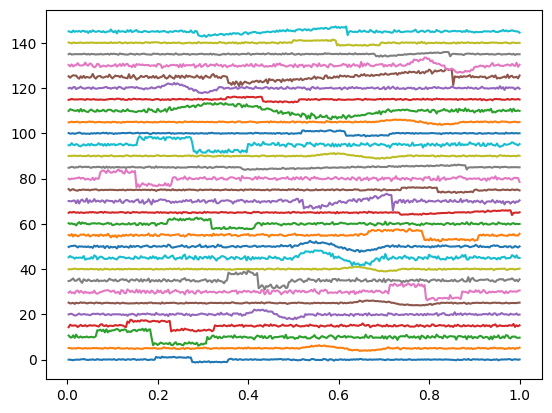

In [4]:
time, data, data_labels = generate_data(nsignals = 30)

nsignals = len(data)
for n in range(nsignals):
    plt.plot(time, data[n,:]+5*n)
plt.show()   

## Preprocessing

The TKEO (Teager-Kaiser Energy Operator) operator is applied and then the signals are standard normalized.

The TKEO energy operator is defined as: y[i] = x[i]<sup>2</sup> -x[i-1] * x[i+1]. The TKEO operator is used to increase the ratio  of the event signal relative to the background noise and improves prediction accuracy.

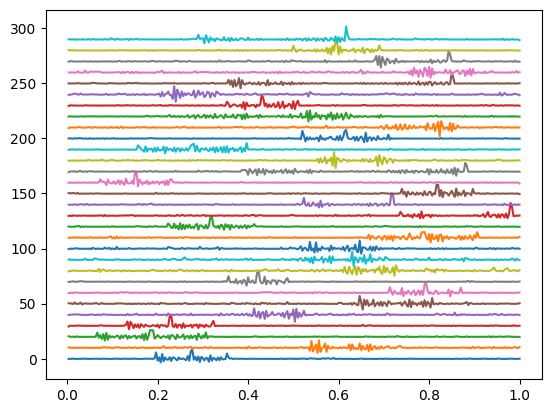

In [5]:
#standard scaler
filt_data = standard_scaler(data)

#tkeo operator 
filt_data = tkeo_operator(data)

#standard scaler
filt_data = standard_scaler(filt_data)

for n in range(nsignals):
    plt.plot(time, filt_data[n,:]+10*n)
plt.show()

### Remove event from background noise

A thresholding technique is used to separate the event from the background noise. For each signal, the function calculates a running standard deviation and separates the event from the background noise based on where the running standard deviation is above a given threshold. This step isn't strictly necessary, but it helps speed up dtw calculations. 

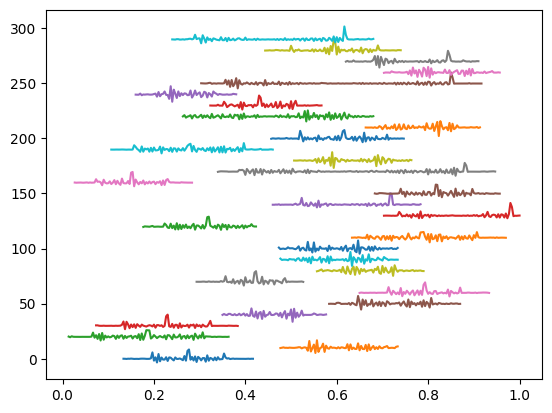

In [6]:
indxs = segment_data(filt_data, pad = 10, thresh = 1, k=10)

for i in range(nsignals):
    
    plt.plot(time[indxs[i][0]:indxs[i][1]],filt_data[i][indxs[i][0]:indxs[i][1]]+10*i)
plt.show()

### DTW correlation matrix

DTW is calculated between each signal and each other signal of the generated data. At each iteration a first signal is first warped to a second signal and a correlation between the warped first signal and the second matched signal is calculated. Then the second signal is warped to the first signal and a correlation between the warped second signal and matched first signal is calculated. These correlation values are stored in a square correlation matrix where row indexes match indexes of the warped signals and column indexes match indexes of the matched signals. 


In [7]:
dtw_dists = dtw_correlation(data = filt_data, window_size = 30, indices = indxs)

## Kmeans Clustering

K-means clustering is performed on the dtw correlation matrix with n=3, and a cluster purity score is calculated. Based on the purity score, it is apparent that clusters recognized by the k-means algorithm are homogenous relative to event type. 

In [8]:
#kmeans clustering
kmeans_model = KMeans(n_clusters = 3)
clusters = kmeans_model.fit_predict(dtw_dists)

#calculate purity score
correspondence, purity = purity_score(3, data_labels, clusters)
print('purity score: {}'.format(purity))

purity score: 1.0


/Users/joaoreis/anaconda3/envs/nds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### TSNE Visualization

Dimensional reduction on the dtw correlation matrix is performed using t-sne and plotted for visualization. The cluster centroids derived from k-means are also plotted. The points are marked according to data labels generated during the initial data generation step. 

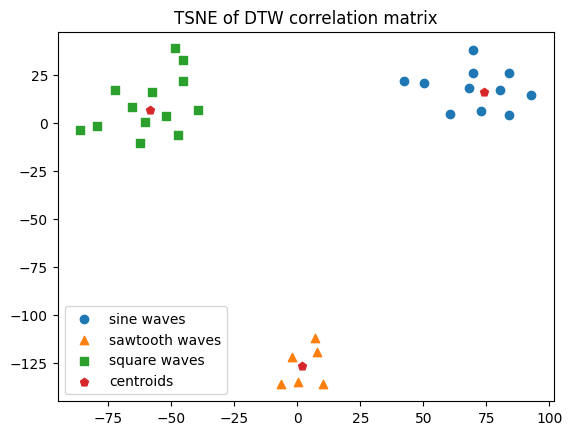

In [9]:
tsne_visualization(dtw_dists, kmeans_model.cluster_centers_, data_labels)

## Predicting new data

The signals in each of the k-means clusters are averaged using barycenter averaging to yield an average representative signal for each cluster, the results of which are plotted below.

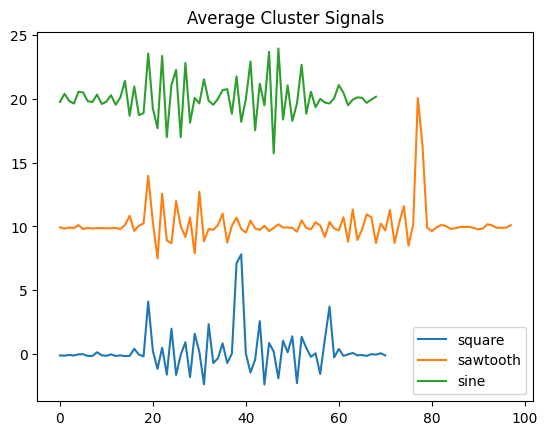

In [10]:
time_index_list, average_signal_list = average_incluster_signals(filt_data, indxs, clusters, dtw_dists)

for i in range(len(average_signal_list)):
    if correspondence[i] == 1:
        label = 'sine'
    elif correspondence[i]==2:
        label = 'sawtooth'
    else:
        label = 'square'
    plt.plot(time_index_list[i], average_signal_list[i]+10*i, label = label)
plt.legend()
plt.title('Average Cluster Signals')
plt.show()

### Generate New Data and Preprocess

One hundred new signals are generated in the same manner as before.

In [11]:
time, test_data, data_labels = generate_data(nsignals = 100)
test_indxs, test_filt_data = preprocessing(test_data)

### Predict test data using dtw distances with average cluster signals

Dtw distances are calculated between each of the new test signals and each of the three representative signals. The predicted data label is assigned based on which representative signal yields the smallest dtw distance with any given test signal. A new purity score is calculated and printed below. As can be seen from the result, we can expect a prediction accuracy using this method of roughly 90%.

In [12]:
predicted_labels = predict_test_data(test_filt_data, test_indxs,average_signal_list, 30)
_, purity = purity_score(3, data_labels, predicted_labels)
print('purity score: {}'.format(purity))

purity score: 0.96
